https://www.tensorflow.org/tutorials/keras/regression

# Basic regression: Predict fuel efficiency

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic <a href="https://archive.ics.uci.edu/ml/datasets/auto+mpg">Auto MPG</a> dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras <a href="https://www.tensorflow.org/tutorials/keras">tutorials</a> and <a href="https://www.tensorflow.org/guide/keras">guides</a> to learn more.)

In [3]:
# Use seaborn for pairplot.
#!pip install -q seaborn

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2024-05-27 04:46:38.598830: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 04:46:38.602210: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 04:46:38.640267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 04:46:39.499211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


### The Auto MPG dataset

The dataset is available from the <a href="https://archive.ics.uci.edu/ml/">UCI Machine Learning Repository</a>.

#### Get the data

First download and import the dataset using pandas:

In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [7]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data
The dataset contains a few unknown values:

In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [9]:
dataset = dataset.dropna()

The "Origin" column is categorical, not numeric. So the next step is to one-hot encode the values in the column with <a href="https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html">pd.get_dummies</a>.

In [10]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [11]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


### Split the data into training and test sets
Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

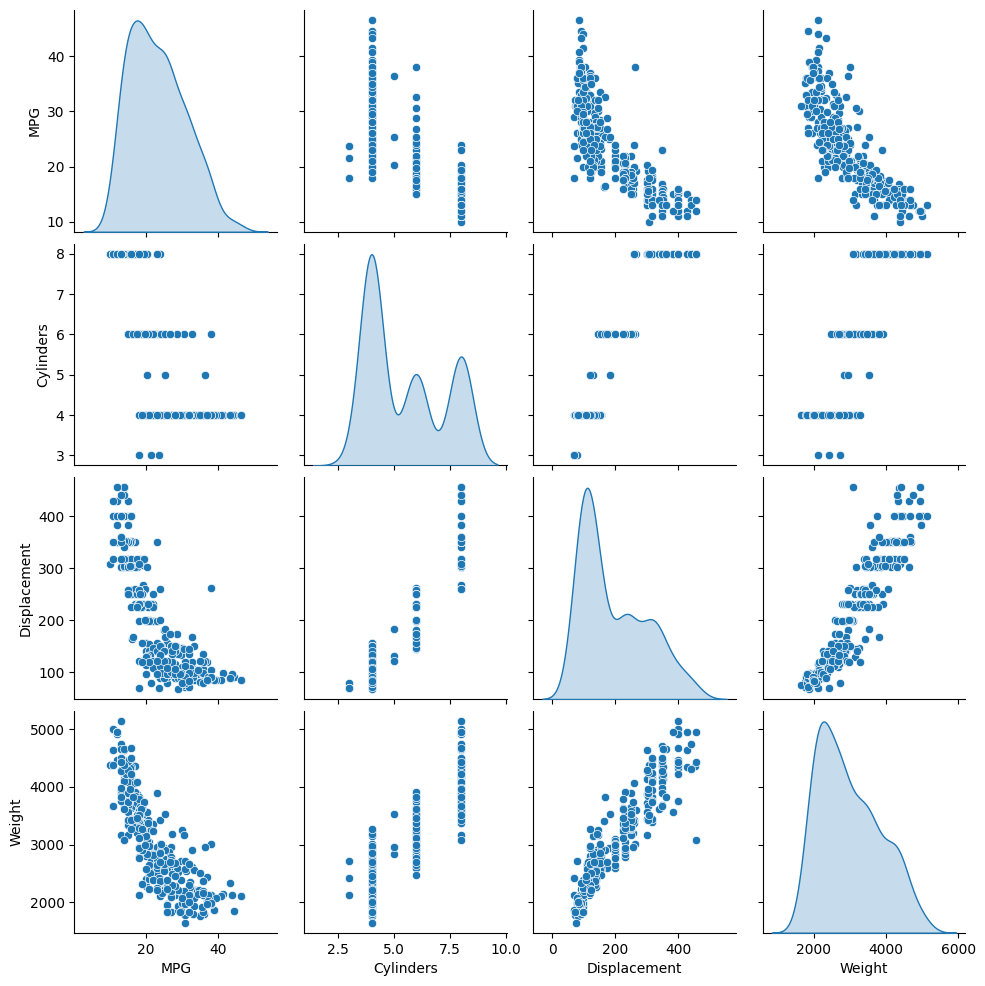

In [13]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### Split features from labels
Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

### Normalization
In the table of statistics it's easy to see how different the ranges of each feature are:

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

### The Normalization layer

The <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization">tf.keras.layers.Normalization</a> is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [17]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization#adapt">Normalization.adapt</a>:

In [19]:
normalizer.adapt(np.array(train_features))


Calculate the mean and variance, and store them in the layer:

In [20]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [21]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[4 90.0 75.0 2125.0 14.5 74 False False True]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


### Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

#### Linear regression with one variable

Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.

Training a model with <a href="https://www.tensorflow.org/api_docs/python/tf/keras">tf.keras</a> typically starts by defining the model architecture. Use a <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">tf.keras.Sequential</a> model, which <a href="https://www.tensorflow.org/guide/keras/sequential_model">represents a sequence of steps</a>.

There are two steps in your single-variable linear regression model:

<ul>
    <li>Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.</li>
    <li>Apply a linear transformation (y = mx + b) to produce 1 output using a linear layer (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense">tf.keras.layers.Dense</a>).</li>
</ul>

The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the 'Horsepower' features. Then, instantiate the tf.keras.layers.Normalization and fit its state to the horsepower data:

In [23]:
horsepower = np.array(train_features['Horsepower'])

#horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the Keras Sequential model:

In [24]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

This model will predict 'MPG' from 'Horsepower'.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of (10, 1):

In [25]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


array([[ 0.611],
       [ 0.345],
       [-1.128],
       [ 0.857],
       [ 0.775],
       [ 0.304],
       [ 0.918],
       [ 0.775],
       [ 0.202],
       [ 0.345]], dtype=float32)

Once the model is built, configure the training procedure using the Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile">Model.compile</a> method. The most important arguments to compile are the loss and the optimizer, since these define what will be optimized (mean_absolute_error) and how (using the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam">tf.keras.optimizers.Adam</a>).

In [26]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit">Model.fit</a> to execute the training for 100 epochs:

In [27]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.96 s, sys: 190 ms, total: 4.15 s
Wall time: 3.78 s


Visualize the model's training progress using the stats stored in the history object:

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.793587,4.191519,95
96,3.823683,4.195251,96
97,3.789640,4.194185,97
98,3.783240,4.198901,98
99,3.807515,4.206064,99


In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

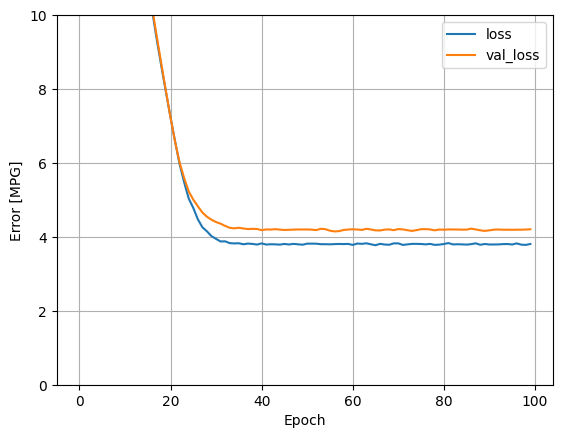

In [30]:
plot_loss(history)

Collect the results on the test set for later:

In [31]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [32]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [33]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

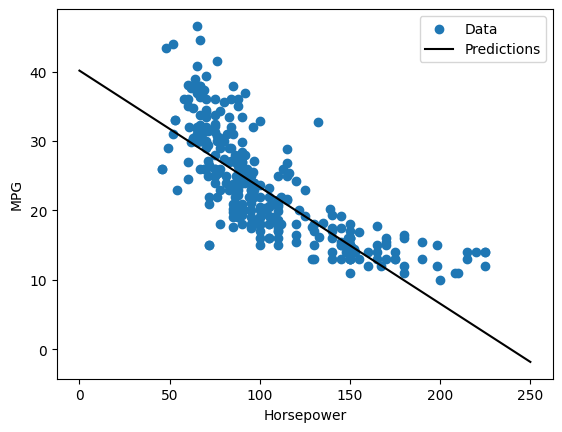

In [34]:
plot_horsepower(x, y)

### Linear regression with multiple inputs
You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same "y = mx + b" except that "m" is a matrix and "x" is a vector.

Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)) you defined earlier and adapted to the whole dataset:

In [35]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict">Model.predict</a> on a batch of inputs, it produces units=1 outputs for each example:

In [40]:
# tensorflow, didn't like the ints or the bools.  Converted all of them to float64.  Not sure, why they didn't have this problem
train_features["Cylinders"] = train_features["Cylinders"].astype("float64")
train_features["Model Year"] = train_features["Model Year"].astype("float64")
train_features["Europe"] = train_features["Europe"].astype("float64")
train_features["Japan"] = train_features["Japan"].astype("float64")
train_features["USA"] = train_features["USA"].astype("float64")

In [41]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


array([[ 0.719],
       [ 0.6  ],
       [-2.471],
       [ 1.791],
       [ 2.006],
       [-0.367],
       [ 2.061],
       [ 0.707],
       [-0.77 ],
       [ 0.826]], dtype=float32)

When you call the model, its weight matrices will be built—check that the kernel weights (the in ) have a shape of (9, 1):linear_model.layers[1].kernel

In [42]:
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_1/dense_1/kernel>

Configure the model with Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile">Model.compile</a> and train with <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit">Model.fit</a> for 100 epochs:

In [43]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [44]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.97 s, sys: 211 ms, total: 4.18 s
Wall time: 3.82 s


Using all the inputs in this regression model achieves a much lower training and validation error than the horsepower_model, which had one input:

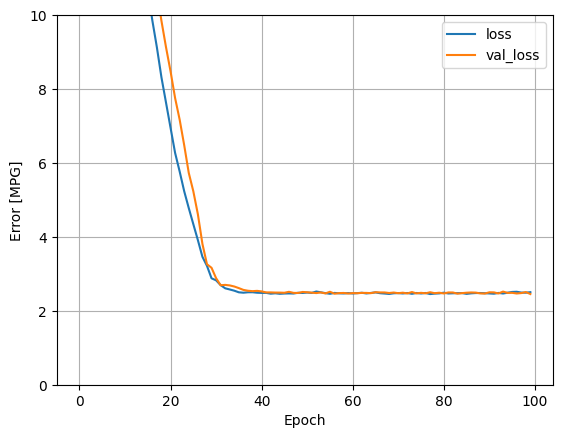

In [45]:
plot_loss(history)

Collect the results on the test set for later:

In [50]:
test_features["Cylinders"] = test_features["Cylinders"].astype("float64")
test_features["Model Year"] = test_features["Model Year"].astype("float64")
test_features["Europe"] = test_features["Europe"].astype("float64")
test_features["Japan"] = test_features["Japan"].astype("float64")
test_features["USA"] = test_features["USA"].astype("float64")

In [51]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)